### Repeat of MLP
January 27 2020 

In [1]:
# load libs
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.preprocessing import OneHotEncoder

In [2]:
# load mnist
X, y = fetch_openml('mnist_784', version=1, return_X_y=True)
print(X.dtype, y.dtype, X.shape, y.shape, X.max(), X.min(), y.max(), y.min())

# preprocess
X = X.T / 255.0
Y = OneHotEncoder().fit_transform(y.reshape(-1, 1).astype('int32')).toarray().T # one hot labeld
print(X.shape, Y.shape)

float64 object (70000, 784) (70000,) 255.0 0.0 9 0
(784, 70000) (10, 70000)


(784, 70000) (10, 70000)


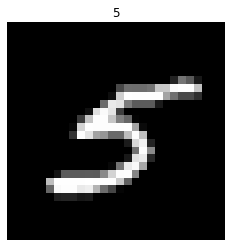

In [3]:
# make train/test splits
m = 60000
X_train, X_test = X[:,:m], X[:,m:]
Y_train, Y_test = Y[:,:m], Y[:,m:]
print(X.shape, Y.shape)

# randomly shuffle trainset
np.random.seed(123456) # for reproducibility
shuffle = np.random.permutation(m)
X_train, Y_train = X_train[:,shuffle], Y_train[:,shuffle]

# visual check
sample = np.random.randint(m)
plt.imshow(X_train[:,sample].reshape(28, -1), cmap = 'binary_r')
plt.axis('off')
plt.title(np.argmax(Y_train[:,sample]))
plt.show()


In [4]:
# implement 3 layers mlp

# define network: 
n_samples = 60000
input_dims = 784
hidden_dims = 128
output_dims = 10
epochs = 1000
lr = [0.01, 0.1, 1]

# initialize weights/bias
W1 = np.random.randn(hidden_dims, input_dims) # 128 * 784
W2 = np.random.randn(output_dims, hidden_dims) # 10 * 128
b1 = np.zeros((hidden_dims, 1)) # 128 * 1
b2 = np.zeros((output_dims, 1)) # 10 * 1

# train network
Losses = []
for ep in range(epochs):
    if ep == 0: lr = 1
    elif ep == 100: lr = 0.1
    elif ep == 500: lr = 0.01

    # forward pass
    Z1 = W1 @ X_train + b1 # (128, 784) @ (784, 60000) + (128, 1)
    A1 = 1 / (1 + np.exp(-Z1)) # sigmoid: 128 * 60000
    Z2 = W2 @ A1 + b2 # (10, 32) @ (128, 60000) + (10, 1)
    A2 = np.exp(Z2) / np.exp(Z2).sum(axis = 0) # 10 * 60000, prob for each class

    # calculate loss
    Loss = -np.sum(Y_train * np.log(A2))/n_samples # scaler
    Losses.append(Loss)

    # backward pass
    dZ2 = A2 - Y_train # 10 * 60000, dL/dZ2 = Y_hat - Y (square-error-like)
    dW2 = dZ2 @ A1.T / n_samples # (10,60000) @ (10, 128).T / 60000
    db2 = dZ2.sum(axis = 1, keepdims = True)/n_samples # (10, 1) <== (10, 60000).sum(axis = 1, keepdims= True)

    dA1 = W2.T @ dZ2 # (10 * 784).T @ (10, 60000) ==> (784, 60000)
    dZ1 = dA1 * A1 * (1 - A1) # d_sigmoid
    dW1 = dZ1 @ X_train.T / n_samples
    db1 = dZ1.sum(axis=1, keepdims = True)/n_samples

    # update W/b
    W1 -= lr * dW1
    W2 -= lr * dW2
    b1 -= lr * db1
    b2 -= lr * db2

    if ep % 100 == 0:
        print('Epoch %2d : %.5f'%(ep, Loss))
        


Epoch  0 : 10.29487
Epoch 100 : 0.74835
Epoch 200 : 0.71671
Epoch 300 : 0.68924
Epoch 400 : 0.66509
Epoch 500 : 0.64361
Epoch 600 : 0.64159
Epoch 700 : 0.63959
Epoch 800 : 0.63761
Epoch 900 : 0.63566


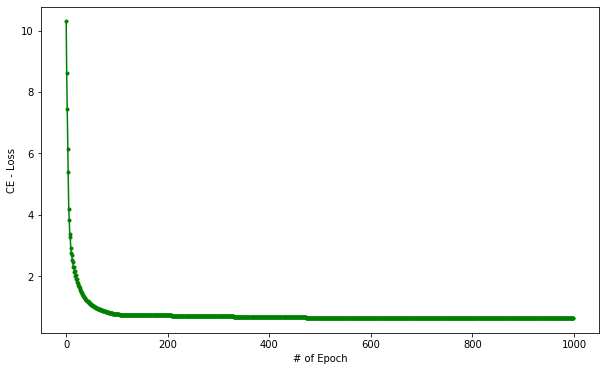

In [5]:
# plot losses
plt.figure(figsize = (10, 6))
plt.plot(range(len(Losses)), Losses, c = 'g', marker = '.')
plt.xlabel('# of Epoch')
plt.ylabel('CE - Loss')
plt.show()

In [6]:
# test network
Z1 = W1 @ X_test + b1
A1 = 1/(1+np.exp(-Z1))
Z2 = W2 @ A1 + b2
A2 = np.exp(Z2)/np.exp(Z2).sum(axis = 0) # 10 * 60000

preds = np.argmax(A2, axis = 0) # 10 * 10000
truth = np.argmax(Y_test, axis = 0) # 10 * 10000

In [7]:
# print accuracy
print('accuracy score')
print(accuracy_score(truth, preds))

accuracy score
0.8283


In [8]:
print('confusion matrix')
print(confusion_matrix(truth,preds))

confusion matrix
[[ 896    0    6    6    3   34   20    4    8    3]
 [   0 1079   11    8    2    6    2    1   25    1]
 [  21   14  829   33   12    7   25   27   51   13]
 [   9    1   34  823    6   50   11   21   44   11]
 [   6    5    6    3  802   14   31   15   11   89]
 [  23    7   12   83   17  635   24   19   52   20]
 [  21    5   17    4   18   22  850    4    9    8]
 [  13   16   43   17   17    6    3  851   10   52]
 [  12   10   29   41   10   74   13   19  749   17]
 [  13    9   10   12   95   21    8   55   17  769]]


In [9]:
print('classification report')
print(classification_report(truth, preds))

classification report
              precision    recall  f1-score   support

           0       0.88      0.91      0.90       980
           1       0.94      0.95      0.95      1135
           2       0.83      0.80      0.82      1032
           3       0.80      0.81      0.81      1010
           4       0.82      0.82      0.82       982
           5       0.73      0.71      0.72       892
           6       0.86      0.89      0.87       958
           7       0.84      0.83      0.83      1028
           8       0.77      0.77      0.77       974
           9       0.78      0.76      0.77      1009

    accuracy                           0.83     10000
   macro avg       0.83      0.83      0.83     10000
weighted avg       0.83      0.83      0.83     10000

